In [5]:
!pip install transformers==4.40.0

In [10]:
!wget https://rserve.dataverse.harvard.edu/cgi-bin/zipdownload?4ea-ed5dc3a7f82f

--2024-04-23 20:15:31--  https://rserve.dataverse.harvard.edu/cgi-bin/zipdownload?4ea-ed5dc3a7f82f
Resolving rserve.dataverse.harvard.edu (rserve.dataverse.harvard.edu)... 52.20.13.250, 18.211.97.47, 52.6.4.72
Connecting to rserve.dataverse.harvard.edu (rserve.dataverse.harvard.edu)|52.20.13.250|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-04-23 20:15:31 ERROR 404: Not Found.



In [11]:
from transformers import AutoTokenizer
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like bert-base-cased is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [4]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

plt.style.use('ggplot')
np.__version__

'1.21.6'

## Loading the data

In [ ]:
df = pd.read_csv('/kaggle/input/symptom2disease/Symptom2Disease.csv')
df.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


<AxesSubplot:>

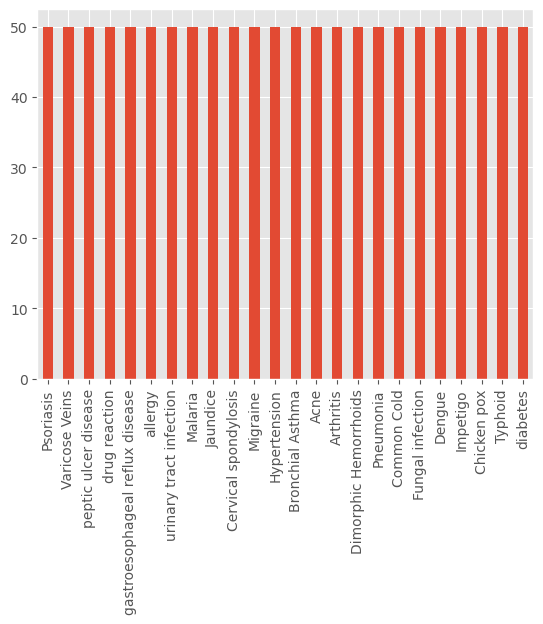

In [ ]:
df['label'].value_counts().plot(kind='bar')

## Input length distribution

  0%|          | 0/1200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distribution of length')

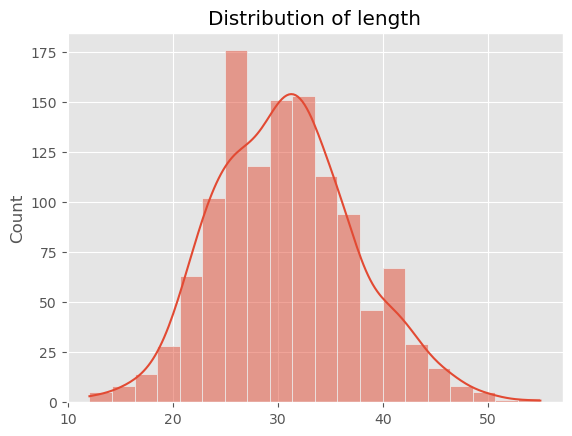

In [ ]:
length = []
for txt in tqdm(df['text'].values):
    length.append(len(txt.split()))

sea.histplot(length, kde = True, bins = 20)
plt.title('Distribution of length')

In [ ]:
int2label = {}

for i, disease in enumerate(df['label'].unique()):
    int2label[i] = disease

label2int = {v : k for k, v in int2label.items()}
num_classes = len(int2label)

print(int2label)
print(label2int)

df['label'] = df['label'].map(lambda x : label2int[x])

X, y = df['text'].values, df['label'].values

x_tokenizer = Tokenizer(filters = '')
x_tokenizer.fit_on_texts(X)
x_vocab = len(x_tokenizer.word_index) + 1
print("X vocab:", x_vocab)

({0: 'Psoriasis',
  1: 'Varicose Veins',
  2: 'Typhoid',
  3: 'Chicken pox',
  4: 'Impetigo',
  5: 'Dengue',
  6: 'Fungal infection',
  7: 'Common Cold',
  8: 'Pneumonia',
  9: 'Dimorphic Hemorrhoids',
  10: 'Arthritis',
  11: 'Acne',
  12: 'Bronchial Asthma',
  13: 'Hypertension',
  14: 'Migraine',
  15: 'Cervical spondylosis',
  16: 'Jaundice',
  17: 'Malaria',
  18: 'urinary tract infection',
  19: 'allergy',
  20: 'gastroesophageal reflux disease',
  21: 'drug reaction',
  22: 'peptic ulcer disease',
  23: 'diabetes'},
 {'Psoriasis': 0,
  'Varicose Veins': 1,
  'Typhoid': 2,
  'Chicken pox': 3,
  'Impetigo': 4,
  'Dengue': 5,
  'Fungal infection': 6,
  'Common Cold': 7,
  'Pneumonia': 8,
  'Dimorphic Hemorrhoids': 9,
  'Arthritis': 10,
  'Acne': 11,
  'Bronchial Asthma': 12,
  'Hypertension': 13,
  'Migraine': 14,
  'Cervical spondylosis': 15,
  'Jaundice': 16,
  'Malaria': 17,
  'urinary tract infection': 18,
  'allergy': 19,
  'gastroesophageal reflux disease': 20,
  'drug reacti

## Train Test Data split

In [ ]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1, stratify = y)
train_x.shape, val_x.shape, train_y.shape, val_y.shape


((1080,), (120,), (1080,), (120,))

In [ ]:
from transformers import AutoTokenizer
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
train_encodings = tokenizer(list(train_x), padding="max_length", truncation=True)
val_encodings = tokenizer(list(val_x), padding="max_length", truncation=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
)).batch(BATCH_SIZE)


In [ ]:
pip install keras --upgrade

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


## Pretrained BERT Model loading

In [ ]:
num_classes = 24

from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels = num_classes,
    id2label = int2label,
    label2id = label2int,
    output_attentions = True)

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 3e-5),
    metrics = ['accuracy'])


# fine tuning

history = model.fit(train_dataset,
          epochs = 3,
          validation_data = val_dataset)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
135/135 [==============================] - 125s 608ms/step - loss: 2.6322 - accuracy: 0.3574 - val_loss: 1.7140 - val_accuracy: 0.7667
Epoch 2/3
135/135 [==============================] - 79s 584ms/step - loss: 1.0741 - accuracy: 0.9000 - val_loss: 0.5308 - val_accuracy: 0.9417
Epoch 3/3
135/135 [==============================] - 79s 584ms/step - loss: 0.3602 - accuracy: 0.9852 - val_loss: 0.2243 - val_accuracy: 0.9583


## loss and accuracy plots.

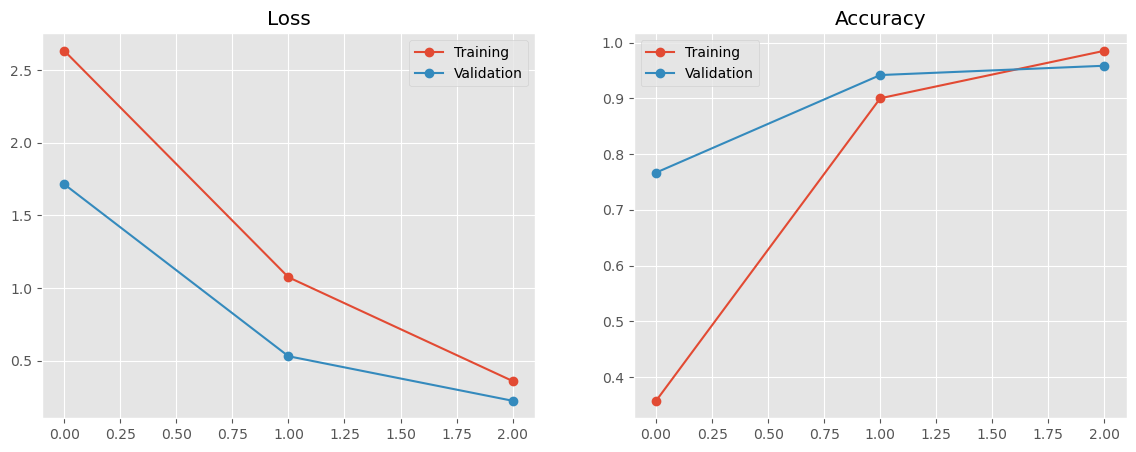

In [ ]:
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = 'o', label = 'Training')
plt.plot(history.history['val_loss'], marker='o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = 'o', label = 'Training')
plt.plot(history.history['val_accuracy'], marker='o', label = 'Validation')
plt.legend()


In [ ]:
# Saving the model
model_save_directory = "./saved_model"
model.save_pretrained(model_save_directory)

# Saving the tokenizer
tokenizer_save_directory = "./saved_tokenizer"
tokenizer.save_pretrained(tokenizer_save_directory)

('./saved_tokenizer/tokenizer_config.json',
 './saved_tokenizer/special_tokens_map.json',
 './saved_tokenizer/vocab.txt',
 './saved_tokenizer/added_tokens.json',
 './saved_tokenizer/tokenizer.json')